In [1]:
#!/usr/bin/env python
import sys
import numpy as np
import pandas as pd
import pickle
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # or any {'0', '1', '2'}

import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv1D,
    ZeroPadding2D,
    Activation,
    Input,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAvgPool1D, MaxPooling1D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, ReLU
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import activations
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy.random as rng
from common_funcs_2 import pad_seqs_to_onehot
import common_funcs_2 as cf
import argparse
import json
import utils
import model_def

In [28]:
def plot_predicted(df_sample, model, title=" ", is_rmsd=False, ):
    import scipy
    q_seqs = df_sample.qseq.values
    t_seqs = df_sample.tseq.values
    tmalign_distance = df_sample.distance

    q_seqs_ohe = pad_seqs_to_onehot(
        q_seqs, padded_len, max_seq_len, random_padding=False, center_padding=True, dtype=np.int8,
    )

    t_seqs_ohe = pad_seqs_to_onehot(
        t_seqs, padded_len, max_seq_len, random_padding=False, center_padding=True, dtype=np.int8,
    )

    # float16 greatly reduces df saving time.
    predicted_distance = np.array(model.predict([q_seqs_ohe, t_seqs_ohe]).flatten())
    mae = np.mean(np.abs(predicted_distance - tmalign_distance))
    
    R, p = scipy.stats.pearsonr(tmalign_distance, predicted_distance)
    title = "{}: Pearson MAE={:.3f}\n{}".format(title, mae, time_stamp)

    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor("white")
    if is_rmsd:
        plt.axis((0.0, 9, 0.0, 9))        
        plt.plot([0, 9], [0, 9], color="red")
    else:
        plt.axis((0.0, 1, 0.0, 1))
        plt.plot([0, 1], [0, 1], color="red")
        
    plt.scatter(tmalign_distance, predicted_distance, s=0.1)

    plt.title(title)
    plt.xlabel("Actual Distance")
    plt.ylabel("Predicted Distance")
    file_name = SAVE_PLOTS_DIR + time_stamp + "-TEST-actual_vs_predicted.png"
    #plt.savefig(file_name, format="png", pad_inches=0.3)
    plt.show()
    return predicted_distance

In [3]:
def plot_tm_vs_rmsd(df_sampled):
    max_tm_scores = np.maximum(df_sampled["TM1"], df_sampled["TM2"])
    y = 1 - max_tm_scores
    x = df_sampled.RMSD.values

    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor("white")
    plt.axis((0.0, 9, 0.0, 1))
    plt.plot([0, 9], [0, 1], color="red")
    plt.scatter(x, y, s=0.01)
    #plt.title(title)
    plt.xlabel("RMSD")
    plt.ylabel("1-TMscore")
    plt.show()

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs detected:", len(physical_devices))

Num GPUs detected: 4


In [5]:
with open("config.json", "r") as f:
    p = json.load(f)

In [6]:
time_stamp = cf.date_stamp()
p["date_time"] = time_stamp
p["config_file_name"] = "save/configs/" + p["date_time"] + ".json"

SCRATCH_PATH = p["SCRATCH_PATH"]
DATA_PATH = SCRATCH_PATH + "/ML/struct/"
SAVE_PLOTS_DIR = SCRATCH_PATH + "/ML/struct/save/plots/"
SAVE_WEIGHTS_DIR = SCRATCH_PATH + "/ML/struct/save/weights/"
CHECKPOINT_DIR = SCRATCH_PATH + "/ML/struct/save/chkpt/"

In [7]:
max_seq_len = 400
padded_len = max_seq_len + 10

#Use the holdout set for training, 
df_double_holdout = pd.read_pickle("SCORES_MINI_TRAIN.pkl.gz") #.sample(10000, random_state=424242)
df_train_and_val  = pd.read_pickle("SCORES_MINI_HOLDOUT.pkl.gz")

#max_tm_scores = np.maximum(df_train_and_val["TM1"], df_train_and_val["TM2"])
#df_train_and_val["distance"] = (1 - max_tm_scores).astype(np.float16)
df_train_and_val["distance"] = df_train_and_val['RMSD'].values.astype(np.float16)
#df_train_and_val["distance"] = 1 - df_train_and_val["TM1"].astype(np.float16)
#print("Generating random distances...")
#df_train_and_val["distance"] = np.random.uniform(0,1,len(max_tm_scores))

#max_tm_scores_ho = np.maximum(df_double_holdout["TM1"], df_double_holdout["TM2"])
#df_double_holdout["distance"] = (1 - max_tm_scores_ho).astype(np.float16)
df_double_holdout["distance"] = df_double_holdout["RMSD"].values.astype(np.float16) 
#df_double_holdout["distance"] = 1 - df_double_holdout["TM1"].astype(np.float16)

In [8]:
# df_train, df_validation = train_test_split(
#      df_train_and_val, test_size=0.0001, random_state=425364
# )

In [9]:
print("Training set size:", len(df_train_and_val))
print("Double-holdout set size:", len(df_double_holdout))
# print("Validation set size:", len(df_validation))

Training set size: 65714
Double-holdout set size: 10000


# Load the complete set

In [10]:
# df_scores_all = pd.read_pickle(DATA_PATH + "SCORES.pkl.gz")
# max_tm_scores = np.maximum(df_scores_all["TM1"], df_scores_all["TM2"])
# df_scores_all["distance"] = 1 - max_tm_scores
# max_seq_len = p["MAX_SEQ_LEN"]
# print("Discarding pairs >{} residues, and TMscore>{:.2f}".format(max_seq_len, p["TMSCORE_CUTOFF"]))

# # Select the training set.
# length_filter = (df_scores_all.qlen <= max_seq_len) & (
#     df_scores_all.tlen <= max_seq_len
# )
# tm_score_filter = df_scores_all.distance < (1 - p["TMSCORE_CUTOFF"])

# train_filter = length_filter & tm_score_filter & (df_scores_all.train_or_holdout == 0)
# df_train_and_val = df_scores_all[train_filter]

# Model

In [20]:
epochs = 5

In [12]:
model = model_def.get_siamese_model(padded_len=padded_len, output_dim=300)

(410, 20)


In [13]:
optimizer = Adam(lr=0.0005)
model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [14]:
train_gen = model_def.DataGenerator(df_train_and_val, padded_len, max_seq_len, batch_size=128)
validation_gen = model_def.DataGenerator(df_double_holdout, padded_len, max_seq_len, batch_size=128)

#validation_gen = model_def.DataGenerator(df_train_and_val, padded_len, max_seq_len, batch_size=128)
#train_gen = model_def.DataGenerator(df_double_holdout, padded_len, max_seq_len, batch_size=128)

In [21]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    validation_data=validation_gen,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 513 steps, validate for 78 steps
Epoch 1/5
513/513 [==============================] - 149s 290ms/step - loss: 2.9737 - mae: 1.3193 - val_loss: 2.0203 - val_mae: 1.0549
Epoch 2/5
513/513 [==============================] - 152s 296ms/step - loss: 2.5239 - mae: 1.1855 - val_loss: 1.7322 - val_mae: 0.9614
Epoch 3/5
513/513 [==============================] - 151s 295ms/step - loss: 2.1520 - mae: 1.0855 - val_loss: 1.5193 - val_mae: 0.9088
Epoch 4/5
513/513 [==============================] - 151s 295ms/step - loss: 1.9071 - mae: 1.0273 - val_loss: 1.4814 - val_mae: 0.9027
Epoch 5/5
513/513 [==============================] - 151s 295ms/step - loss: 1.6845 - mae: 0.9811 - val_loss: 1.3503 - val_mae: 0.8781


In [16]:
model.save_weights(SAVE_WEIGHTS_DIR + time_stamp + ".hdf5")

Plotting history...
exponent: -0.48	A: 8.05
Saved history plot to file: ./save/history/History_lin_2020_10_06__17h14m.png


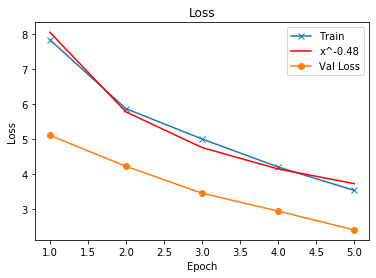

In [17]:
#p['date_time'] = "DUMMY_RUN"
utils.plot_hist(history, p, val_loss=True, scale=None)

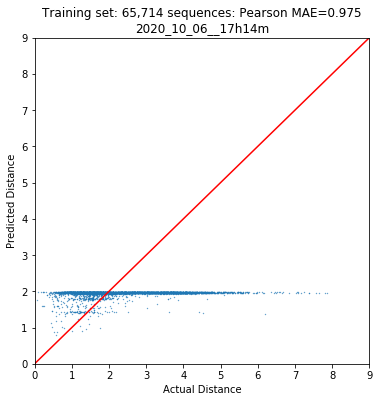

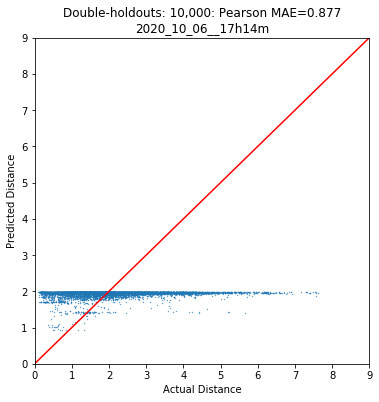

In [27]:
plotting_rmsd = True
SAMPLE_SIZE = 5000 
tr_set_size = len(df_train_and_val)
dholdout_set_size = len(df_double_holdout)
plot_predicted(df_train_and_val.sample(SAMPLE_SIZE), model, "Training set: {:,} sequences".format(tr_set_size), is_rmsd=plotting_rmsd)
plot_predicted(df_double_holdout, model, "Double-holdouts: {:,}".format(dholdout_set_size), is_rmsd=plotting_rmsd)

#plot_predicted(df_train_and_val.sample(SAMPLE_SIZE), "Training set as holdouts: {:,} sequences".format(tr_set_size))
#plot_predicted(df_double_holdout.sample(SAMPLE_SIZE), "Double-holdouts as training set: {:,}".format(dholdout_set_size))

# Debug

In [19]:
plotting_rmsd = True
dholdout_set_size = len(df_double_holdout_complete)
predictions = plot_predicted(df_double_holdout_complete.sample(1000, random_state=4242), "Double-holdouts: {:,}".format(dholdout_set_size), is_rmsd=plotting_rmsd)

NameError: name 'df_double_holdout_complete' is not defined